## Effects of the finite map size

We can try reducing the size of the box for a field with a given $r_0$ and see if $r_0$ is affected:

In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import json
import cmasher as cmr
import seaborn as sns
import sys
import pylab as pl

from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve_fft

from turbustat.simulator import make_ppv
from spectral_cube import SpectralCube  

sys.path.insert(1, 'C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules')  
from turb_utils import make_extended, make_3dfield
import strucfunc
import bfunc

In [2]:
sns.set_color_codes()
sns.set_context("talk")

In [3]:
def split4(arrs):
    """Split each 2D array in list into 4 quadrants

    Returns new list of all the quadrants from each input array.
    Requires that all axis lengths be even.
    """
    rslt = []
    for arr in arrs:
        for vsplit in np.vsplit(arr, 2):
            rslt.extend(np.hsplit(vsplit, 2))
    return rslt


a = np.arange(16).reshape((4, 4))
split4(split4([a]))

[array([[0]]),
 array([[1]]),
 array([[4]]),
 array([[5]]),
 array([[2]]),
 array([[3]]),
 array([[6]]),
 array([[7]]),
 array([[8]]),
 array([[9]]),
 array([[12]]),
 array([[13]]),
 array([[10]]),
 array([[11]]),
 array([[14]]),
 array([[15]])]

This function splits up the whole image into sub-images that are smaller (linearly) by `2**niter` and calculates the mean and std of the $\sigma^2$ and $r_0$ of them:



Copy functions from the seeing notebook.

In [4]:
def split_square_in_4(arr):
    ny, nx = arr.shape
    assert nx == ny and nx % 2 == 0
    slices = slice(None, nx // 2), slice(nx // 2, None)
    corners = []
    for i, j in [
        (0, 0),
        (0, 1),
        (1, 0),
        (1, 1),
    ]:
        corners.append(arr[slices[i], slices[j]])
    return corners

def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def values2arrays(d):
    for k in d.keys():
        if type(d[k]) == list:
            d[k] = np.array(d[k])
    return d

In [5]:
r0 = 32.0
N = 256
m = 1.2

velocity = make_3dfield(
    2*N,
    ellip=0.5,
    theta=45,
    correlation_length=r0,  
    powerlaw=3.0 + m,
    randomseed=2021_10_08)* u.km / u.s  

## Constant density

#density = np.ones((2*N,2*N,2*N))* u.cm**-3  
#n = 100
#density *= n
#density += density.std()  
#density[density.value < 0.] = 0. * u.cm**-3  

## Emissivity fluctuations

density = make_3dfield(2*N, 
                       powerlaw=3.0 + m, 
                       amp=1.,
                       ellip=0.5,
                       theta=45,
                       correlation_length=r0,  
                       randomseed=328764) * u.cm**-3  

density = (density-density.mean())/density.std()

sig_E = 2
emissivity = np.exp(sig_E * density)* u.cm**-3

cube_hdu = make_ppv(velocity, emissivity, los_axis=0,
                    T=10000 * u.K, chan_width=0.5 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  

cube = SpectralCube.read(cube_hdu)  

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)


In [6]:
cube.write('cube_fits//cube_ems_fluct_finite_m12_r32_512_seed1.fits', format='fits')  

In [7]:
cube.moment1().value

array([[0.57064182, 0.58059575, 0.54332243, ..., 0.42955144, 0.5019658 ,
        0.57151447],
       [0.46233561, 0.43221541, 0.4196094 , ..., 0.28256136, 0.36737176,
        0.44147217],
       [0.29128563, 0.28614755, 0.27392653, ..., 0.18486753, 0.2236053 ,
        0.2719628 ],
       ...,
       [0.87110842, 0.80795138, 0.84281418, ..., 0.94402744, 0.99463357,
        0.93143338],
       [0.81650508, 0.78797177, 0.78993358, ..., 0.76486146, 0.77533307,
        0.82042812],
       [0.69456809, 0.67855911, 0.70069243, ..., 0.56981178, 0.5609304 ,
        0.62502981]])

In [8]:

vms_t = split_square_in_4(
    normalize(
      cube.moment1().value  
    )
)

In [9]:

def split4_and_strucfuncs(arrs, niter=1):
    subarrs = arrs.copy()
    for i in range(niter):
        subarrs = split4(subarrs)
    BB = []
    sig2s = []
    r0s = []
    for subarr in subarrs:
        sf = strucfunc.strucfunc_numba_parallel(subarr, dlogr=0.05)
        mask = sf["N pairs"] > 0
        B = sf["Unweighted B(r)"][mask]
        BB.append(B)
        r = 10 ** sf["log10 r"][mask]
        sig2 = np.var(subarr)
        sig2s.append(sig2)
        try:
            i0 = np.argmax(r[B <= sig2])
            i1 = max(0, i0 - 2)
            i2 = min(len(B) - 1, i0 + 2)
            r0 = np.interp(sig2, B[i1:i2], r[i1:i2])
        except:
            r0 = np.nan
        r0s.append(r0)
    r0s = np.array(r0s)
    mgood = np.isfinite(r0s)
    Bmean = np.mean(np.stack(BB), axis=0)
    Bsig = np.std(np.stack(BB), axis=0)
    # calculate quartiles
    Bp25 = np.percentile(np.stack(BB), 25, axis=0)
    Bp75 = np.percentile(np.stack(BB), 75, axis=0)
    Bp05 = np.percentile(np.stack(BB), 5, axis=0)
    Bp95 = np.percentile(np.stack(BB), 95, axis=0)
    return {
        # "subarrs": subarrs,
        "r": r,
        "Bmean": Bmean,
        "Bsig": Bsig,
        "Bp05": Bp05,
        "Bp25": Bp25,
        "Bp75": Bp75,
        "Bp95": Bp95,
        "sig2mean": np.mean(sig2s),
        "sig2sig": np.std(sig2s),
        "sig2_25": np.percentile(sig2s, 25),
        "sig2_75": np.percentile(sig2s, 75),
        "r0mean": np.nanmean(r0s),
        "r0sig": np.nanstd(r0s),
        "r0_25": np.percentile(r0s[mgood], 25),
        "r0_75": np.percentile(r0s[mgood], 75),
    }


splits = {}
for k in [0, 1, 2, 3, 4, 5]:
    splits[2 ** k] = split4_and_strucfuncs(vms_t, k)

    
_split = splits[1]
true_r0 = np.interp(1.0, _split["Bmean"][:-4], _split["r"][:-4])


wdata = {
    "n": [],
    "r0mean": [],
    "r0sig": [],
    "sig2mean": [],
    "sig2sig": [],
}
for ii in splits.keys():
    wdata["n"].append(256 / ii)
    for v1 in "r0", "sig2":
        for v2 in "mean", "sig":
            v = v1 + v2
            wdata[v].append(splits[ii][v])
wdata = values2arrays(wdata)
wdata["r0mean"] /= true_r0
wdata["r0sig"] /= true_r0

bcolors = cmr.take_cmap_colors(
    "cmr.flamingo",
    len(splits.values()),
    cmap_range=(0.05, 0.75),
)

C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


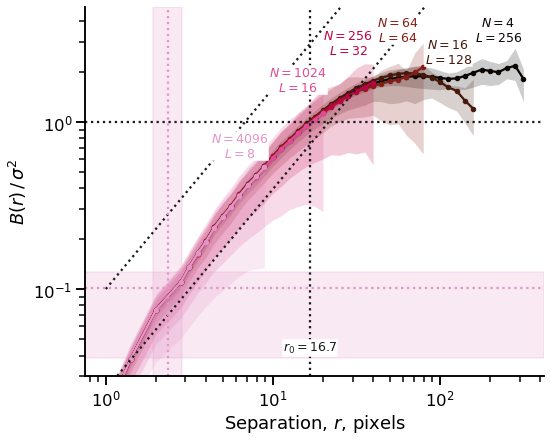

In [10]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)

whitebox = dict(color="white", alpha=1.0, pad=0.0)
L = 256
N = 2
for split, bcolor in zip(splits.values(), bcolors):
    line = ax.plot(split["r"], split["Bmean"], marker=".", color=bcolor)
    c = line[0].get_color()
    # ax.fill_between(
    #    split["r"],
    #    split["Bp05"],
    #    split["Bp95"],
    #    color=c, alpha=0.1, linewidth=0, zorder=-1,
    # )
    ax.fill_between(
        split["r"],
        split["Bp25"],
        split["Bp75"],
        color=c,
        alpha=0.2,
        linewidth=0,
        zorder=-1,
    )
    x, y = split["r"][-4], split["Bp75"][-4] * 1.3
    ax.text(
        x,
        y,
        (rf"$N = {N**2}$" "\n" rf"$L = {L}$"),
        color=c,
        ha="center",
        va="bottom",
        fontsize="x-small",
        bbox=whitebox,
    )
    L //= 2
    N *= 2
# ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.025, 0.1:
    ax.plot(rgrid, scale * rgrid ** m, linestyle="dotted", color="k")

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(true_r0, color="k", linestyle="dotted")

# plot the range of derived r0 and sigma for smallest L
ax.axhline(split["sig2mean"], color=c, linestyle="dotted")
ax.axhspan(
    split["sig2_25"],
    split["sig2_75"],
    color=c,
    alpha=0.2,
)
ax.axvline(split["r0mean"], color=c, linestyle="dotted")
ax.axvspan(
    split["r0_25"],
    split["r0_75"],
    color=c,
    alpha=0.2,
)

ax.text(
    true_r0,
    0.04,
    rf"$r_0 = {true_r0:.1f}$",
    color="k",
    fontsize="x-small",
    ha="center",
    va="bottom",
    bbox=whitebox,
)
ax.set(
    xscale="log",
    yscale="log",
    ylim=[0.03, 4.9],
    xlabel=r"Separation, $r$, pixels",
    ylabel=r"$B(r) \, / \, \sigma^2$",
)
ax.set_aspect("equal")
sns.despine()
fig.tight_layout()
fig.savefig("fake-3d-finite-box-strucfunc-ems-fluct.pdf")

We have now changed this plot to use the 5, 25, 75, 95 centiles of the distributions. This is more realistic than using the mean +/- sigma, although it turns out to not make much difference.

I have also plotted the mean and quartiles of the r0 and sigma for the smallest box `L=8`, which gives $r_0 \approx L/4$

In [11]:
r0 = 32.0
N = 256
m = 1.2

velocity = make_3dfield(
    2*N,
    ellip=0.5,
    theta=45,
    correlation_length=r0,  
    powerlaw=3.0 + m,
    randomseed=2022_04_14)* u.km / u.s  

## Constant density

#density = np.ones((2*N,2*N,2*N))* u.cm**-3  
#n = 100
#density *= n
#density += density.std()  
#density[density.value < 0.] = 0. * u.cm**-3  

## Emissivity fluctuations

density = make_3dfield(2*N, 
                       powerlaw=3.0 + m, 
                       amp=1.,
                       ellip=0.5,
                       theta=45,
                       correlation_length=r0,  
                       randomseed=338764) * u.cm**-3  

density = (density-density.mean())/density.std()

sig_E = 2
emissivity = np.exp(sig_E * density)* u.cm**-3

cube_hdu = make_ppv(velocity, emissivity, los_axis=0,
                    T=10000 * u.K, chan_width=0.5 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  

cube_2 = SpectralCube.read(cube_hdu)  

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)


In [12]:
cube_2.write('cube_fits//cube_ems_fluct_finite_m12_r32_512_seed2.fits', format='fits')  

In [13]:
vmap2x2_t = cube_2.moment1().value

In [14]:
#N = 256
#vmap2x2_t = make_extended(
#    2 * N,
#    powerlaw=2.0 + m,
#    ellip=0.5,
#    theta=45,
#    correlation_length=r0,
##    randomseed=2021_10_08,
#    randomseed=2022_04_14,
#)

In [15]:
normalize(vmap2x2_t)

array([[-0.35480266, -0.33754278, -0.37158872, ..., -0.50459072,
        -0.43203504, -0.34755462],
       [-0.24237055, -0.30057935, -0.36737926, ..., -0.33833401,
        -0.30941989, -0.23451954],
       [-0.12147144, -0.16917612, -0.238352  , ..., -0.22945788,
        -0.2259588 , -0.19086524],
       ...,
       [-1.1550917 , -1.15830946, -1.18375445, ..., -1.10421367,
        -1.15475002, -1.16423804],
       [-0.86985832, -0.95469729, -1.0182388 , ..., -0.79066674,
        -0.89293099, -0.88088213],
       [-0.62450274, -0.64409105, -0.69546329, ..., -0.61310919,
        -0.5692738 , -0.56833879]])

In [16]:
imshow_kwds = dict(origin="lower", vmin=-3, vmax=3, cmap="RdBu_r")

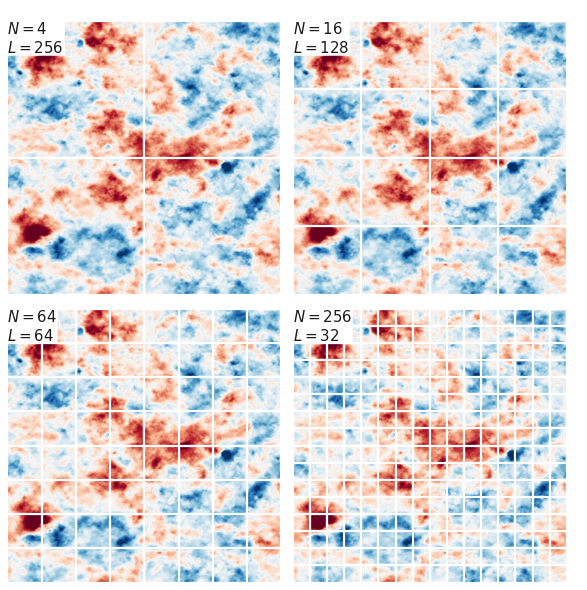

In [17]:
NN = 512
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for ax, N in zip(axes.flat, [2, 4, 8, 16]):
    ax.imshow(
        normalize(vmap2x2_t), 
        **imshow_kwds,
    )
    ax.set(xticks=[], yticks=[])
    L = NN // N
    for i in range(N + 1):
        ax.axhline(i * L, color="w")
        ax.axvline(i * L, color="w")
    ax.text(
        0,
        NN,
        (rf"$N = {N**2}$" "\n" rf"$L = {L}$"),
        color="k",
        ha="left",
        va="top",
        fontsize="small",
        bbox=whitebox,
    )

sns.despine(left=True, bottom=True)
fig.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)
fig.savefig("fake-3d-finite-box-images-ems-fluct.pdf")

In [18]:
N, m, r0

(16, 1.2, 32.0)

In [19]:
N = 256

velocity = make_3dfield(
    2*N,
    ellip=0.5,
    theta=45,
    correlation_length=16,  
    powerlaw=3.0 + m,
    randomseed=2022_04_14)* u.km / u.s  

## Constant density

#density = np.ones((2*N,2*N,2*N))* u.cm**-3  
#n = 100
#density *= n
#density += density.std()  
#density[density.value < 0.] = 0. * u.cm**-3  

## Emissivity fluctuations

density = make_3dfield(2*N, 
                       powerlaw=3.0 + m, 
                       amp=1.,
                       ellip=0.5,
                       theta=45,
                       correlation_length=16,  
                       randomseed=328764) * u.cm**-3  

density = (density-density.mean())/density.std()

sig_E = 2
emissivity = np.exp(sig_E * density)* u.cm**-3

cube_hdu = make_ppv(velocity, emissivity, los_axis=0,
                    T=10000 * u.K, chan_width=0.5 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  

cube_3 = SpectralCube.read(cube_hdu)  

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)


In [20]:
cube_3.write('cube_fits//cube_ems_fluct_finite_m12_r16_512.fits', format='fits')  

In [21]:
vms_r16 = split_square_in_4(
    normalize(
        cube_3.moment1().value
        )
    )


In [22]:
#N = 256
#vms_r16 = split_square_in_4(
#    normalize(
#        make_extended(
#            2 * N,
#            powerlaw=2.0 + m,
#            ellip=0.5,
#            theta=45,
#            correlation_length=16,
#            randomseed=2021_10_08,
#        )
#    )
#)

splits_r16 = {}
for k in [0, 1, 2, 3, 4, 5]:
    splits_r16[2 ** k] = split4_and_strucfuncs(vms_r16, k)

C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


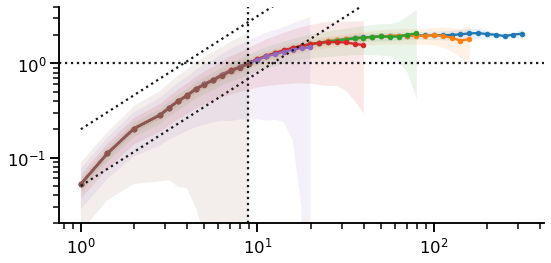

In [23]:
fig, ax = plt.subplots(
    figsize=(8, 4),
)

for split in splits_r16.values():
    line = ax.plot(split["r"], split["Bmean"], marker=".")
    c = line[0].get_color()
    ax.fill_between(
        split["r"],
        split["Bmean"] - split["Bsig"],
        split["Bmean"] + split["Bsig"],
        color=c,
        alpha=0.1,
        linewidth=0,
        zorder=-1,
    )
# ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.05, 0.2:
    ax.plot(rgrid, scale * rgrid ** m, linestyle="dotted", color="k")

_split = splits_r16[1]
true_r0_r16 = np.interp(1.0, _split["Bmean"][:-4], _split["r"][:-4])

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(true_r0_r16, color="k", linestyle="dotted")
ax.set(
    xscale="log",
    yscale="log",
    ylim=[0.02, 4],
)
sns.despine()
fig.tight_layout()

In [24]:
wdata_r16 = {
    "n": [],
    "r0mean": [],
    "r0sig": [],
    "sig2mean": [],
    "sig2sig": [],
}
for ii in splits_r16.keys():
    wdata_r16["n"].append(256 / ii)
    for v1 in "r0", "sig2":
        for v2 in "mean", "sig":
            v = v1 + v2
            wdata_r16[v].append(splits_r16[ii][v])
wdata_r16 = values2arrays(wdata_r16)
wdata_r16["r0mean"] /= 0.5 * true_r0
wdata_r16["r0sig"] /= 0.5 * true_r0

In [25]:
N = 256


velocity = make_3dfield(
    2*N,
    ellip=0.5,
    theta=45,
    correlation_length=16,  
    powerlaw=3.0 + 1.5,
    randomseed=2022_04_14)* u.km / u.s  

## Constant density

#density = np.ones((2*N,2*N,2*N))* u.cm**-3  
#n = 100
#density *= n
#density += density.std()  
#density[density.value < 0.] = 0. * u.cm**-3  

## Emissivity fluctuations

density = make_3dfield(2*N, 
                       powerlaw=3.0 + 1.5, 
                       amp=1.,
                       ellip=0.5,
                       theta=45,
                       correlation_length=16,  
                       randomseed=328764) * u.cm**-3  

density = (density-density.mean())/density.std()

sig_E = 2
emissivity = np.exp(sig_E * density)* u.cm**-3

cube_hdu = make_ppv(velocity, emissivity, los_axis=0,
                    T=10000 * u.K, chan_width=0.5 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  

cube_4 = SpectralCube.read(cube_hdu)  

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)


In [26]:
cube_4.write('cube_fits//cube_ems_fluct_finite_m15_r16_512.fits', format='fits')  

In [27]:
vms_m15 = split_square_in_4(
    normalize(
        cube_4.moment1().value
    )
)

In [28]:
#vms_m15 = split_square_in_4(
#    normalize(
#        make_extended(
#            2 * N,
#            powerlaw=2.0 + 1.5,
#            ellip=0.5,
#            theta=45,
#            correlation_length=16,
#            randomseed=2021_10_08,
#        )
#    )
#)

splits_m15 = {}
for k in [0, 1, 2, 3, 4, 5]:
    splits_m15[2 ** k] = split4_and_strucfuncs(vms_m15, k)

C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


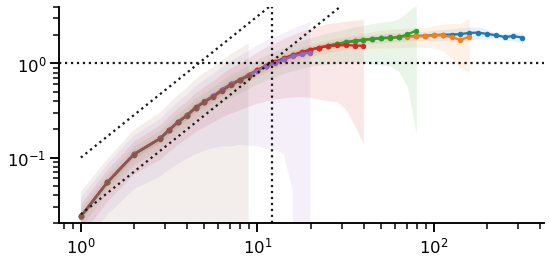

In [29]:
fig, ax = plt.subplots(
    figsize=(8, 4),
)

for split in splits_m15.values():
    line = ax.plot(split["r"], split["Bmean"], marker=".")
    c = line[0].get_color()
    ax.fill_between(
        split["r"],
        split["Bmean"] - split["Bsig"],
        split["Bmean"] + split["Bsig"],
        color=c,
        alpha=0.1,
        linewidth=0,
        zorder=-1,
    )
# ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.025, 0.1:
    ax.plot(rgrid, scale * rgrid ** 1.5, linestyle="dotted", color="k")

_split = splits_m15[1]
true_r0_m15 = np.interp(1.0, _split["Bmean"][:-4], _split["r"][:-4])

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(true_r0_m15, color="k", linestyle="dotted")
ax.set(
    xscale="log",
    yscale="log",
    ylim=[0.02, 4],
)
sns.despine()
fig.tight_layout()

In [30]:
wdata_m15 = {
    "n": [],
    "r0mean": [],
    "r0sig": [],
    "sig2mean": [],
    "sig2sig": [],
}
for ii in splits_m15.keys():
    wdata_m15["n"].append(256 / ii)
    for v1 in "r0", "sig2":
        for v2 in "mean", "sig":
            v = v1 + v2
            wdata_m15[v].append(splits_m15[ii][v])
wdata_m15 = values2arrays(wdata_m15)
wdata_m15["r0mean"] /= true_r0_m15
wdata_m15["r0sig"] /= true_r0_m15

In [31]:
N = 256


velocity = make_3dfield(
    2*N,
    ellip=0.5,
    theta=45,
    correlation_length=16,  
    powerlaw=3.0 + 0.666,
    randomseed=2022_04_14)* u.km / u.s  

## Constant density

#density = np.ones((2*N,2*N,2*N))* u.cm**-3  
#n = 100
#density *= n
#density += density.std()  
#density[density.value < 0.] = 0. * u.cm**-3  

## Emissivity fluctuations

density = make_3dfield(2*N, 
                       powerlaw=3.0 + 0.666, 
                       amp=1.,
                       ellip=0.5,
                       theta=45,
                       correlation_length=16,  
                       randomseed=328764) * u.cm**-3  

density = (density-density.mean())/density.std()

sig_E = 2
emissivity = np.exp(sig_E * density)* u.cm**-3

cube_hdu = make_ppv(velocity, emissivity, los_axis=0,
                    T=10000 * u.K, chan_width=0.5 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  
cube_5 = SpectralCube.read(cube_hdu)  

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)


In [32]:
cube_5.write('cube_fits//cube_ems_fluct_finite_m07_r16_512.fits', format='fits')  

In [33]:
vms_m07 = split_square_in_4(
    normalize(
        cube_5.moment1().value
    )
)


In [34]:
#vms_m07 = split_square_in_4(
#    normalize(
#        make_extended(
#            2 * N,
#            powerlaw=2.0 + 0.666,
#            ellip=0.5,
#            theta=45,
#            correlation_length=16,
#            randomseed=2021_10_08,
#        )
#    )
#)

splits_m07 = {}
for k in [0, 1, 2, 3, 4, 5]:
    splits_m07[2 ** k] = split4_and_strucfuncs(vms_m07, k)

C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


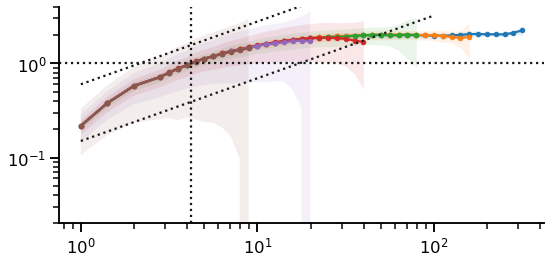

In [35]:
fig, ax = plt.subplots(
    figsize=(8, 4),
)

for split in splits_m07.values():
    line = ax.plot(split["r"], split["Bmean"], marker=".")
    c = line[0].get_color()
    ax.fill_between(
        split["r"],
        split["Bmean"] - split["Bsig"],
        split["Bmean"] + split["Bsig"],
        color=c,
        alpha=0.1,
        linewidth=0,
        zorder=-1,
    )
# ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.15, 0.6:
    ax.plot(rgrid, scale * rgrid ** 0.666, linestyle="dotted", color="k")

_split = splits_m07[1]
true_r0_m07 = np.interp(1.0, _split["Bmean"][:-4], _split["r"][:-4])

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(true_r0_m07, color="k", linestyle="dotted")
ax.set(
    xscale="log",
    yscale="log",
    ylim=[0.02, 4],
)
sns.despine()
fig.tight_layout()

In [36]:
wdata_m07 = {
    "n": [],
    "r0mean": [],
    "r0sig": [],
    "sig2mean": [],
    "sig2sig": [],
}
for ii in splits_m07.keys():
    wdata_m07["n"].append(256 / ii)
    for v1 in "r0", "sig2":
        for v2 in "mean", "sig":
            v = v1 + v2
            wdata_m07[v].append(splits_m07[ii][v])
wdata_m07 = values2arrays(wdata_m07)
wdata_m07["r0mean"] /= true_r0_m07
wdata_m07["r0sig"] /= true_r0_m07

Empirical fit to the finite-box effect.  This turns out to be very simple:

In [37]:
def finite_box_effect(L_over_r0, scale=3.6):
    return 1 - np.exp(-L_over_r0 / scale)

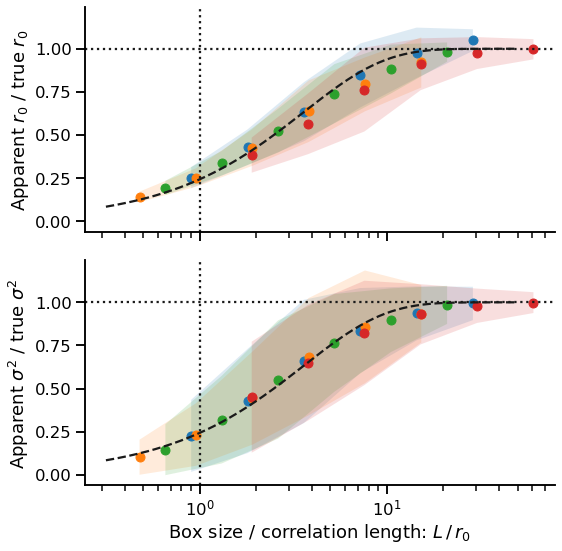

In [64]:
fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    sharex=True,
    sharey=True,
    figsize=(8, 8),
)
for data, corr_length in [
    [wdata_r16, true_r0_r16],
    [wdata, true_r0],
    [wdata_m15, true_r0_m15],
    [wdata_m07, true_r0_m07],
]:
    x = data["n"] / corr_length
    ax1.plot(x, data["r0mean"], linestyle="none", marker="o")
    ax1.fill_between(
        x,
        data["r0mean"] - data["r0sig"],
        data["r0mean"] + data["r0sig"],
        alpha=0.15,
        lw=0,
        zorder=-1,
    )
    ax2.plot(x, data["sig2mean"], linestyle="none", marker="o")
    ax2.fill_between(
        x,
        data["sig2mean"] - data["sig2sig"],
        data["sig2mean"] + data["sig2sig"],
        alpha=0.15,
        lw=0,
        zorder=-1,
    )
xgrid = np.logspace(-0.5, 1.7, 200)
for ax in [ax1, ax2]:
    ax.axvline(1.0, color="k", linestyle="dotted")
    ax.axhline(1.0, color="k", linestyle="dotted")
    ax.plot(
        xgrid,
        finite_box_effect(xgrid, scale=3.6),
        color="k",
        linestyle="dashed",
    )


ax1.set(
    #ylabel=r"$r_0$ aparente / $r_0$ real",
    ylabel=r"Apparent $r_0$ / true $r_0$",
)
ax2.set(
    xscale="log",
    # yscale="log",
    # xlim=[1, 300],
    # ylim=[0, None],
    #xlabel=r"Tamaño caja / Longitud corr.: $L\, /\, r_0$",
    #ylabel=r"$\sigma^2$ aparente / $\sigma^2$ real",
    xlabel=r"Box size / correlation length: $L\, /\, r_0$",
    ylabel=r"Apparent $\sigma^2$ / true $\sigma^2$",
)
sns.despine()
fig.tight_layout()
fig.savefig("fake-3d-finite-box-effect-ems-fluct.pdf")

In [39]:
true_r0

16.72685399520635

In [40]:
wdata

{'n': array([256., 128.,  64.,  32.,  16.,   8.]),
 'r0mean': array([0.92066566, 0.79336489, 0.63751538, 0.42687235, 0.2532579 ,
        0.14082929]),
 'r0sig': array([0.1454106 , 0.15630962, 0.17849429, 0.10613608, 0.05347869,
        0.03065669]),
 'sig2mean': array([0.93353855, 0.85773588, 0.68451703, 0.44392628, 0.23314313,
        0.10192111]),
 'sig2sig': array([0.16682793, 0.32679335, 0.3400211 , 0.26952978, 0.18117475,
        0.10173061])}

We find that the same function: $1 - \exp(-x / 3.6)$ is an adequate fit to both the $r_0$ and the $\sigma^2$ behaviors.

## Fit the model to the finite box results

To see if we can still recover the true parameters.

In [41]:
import lmfit
import bfunc
import pandas as pd

### Apply to the mean structure functions

We really want to be applying to the individual sub-images and then calulate the mean later.  But, to start with I will just work with what we already have, which is the means.

In [42]:
#Check his
split = splits[32]
r, B = split["r"], split["Bmean"]

In [43]:
def setup_model_params(model, box_size):
    # Correlation length between 1/10 and 2 x box_size
    model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2 * box_size)
    # sig2 between 1/4 and 2 x max value of B(r)
    model.set_param_hint("sig2", value=0.5 * B.max(), min=0.25 * B.max(), max=2 * B.max())
    # m between 1/2 and 5/3
    model.set_param_hint("m", value=1.0, min=0.5, max=2.0)   

In [44]:
def fit_models_to_splits(splits):
    model = lmfit.Model(bfunc.bfunc00s)
    setup_model_params(model, 256)
    fdata = {
        "n": [],
        "L_over_r0": [],
        "r0mean": [],
        "r0sig": [],
        "sig2mean": [],
        "sig2sig": [],
        "mmean": [],
        "msig": [],
        
    }
    for ii in splits.keys():
        fdata["n"].append(256 / ii)
        split = splits[ii]
        r, B = split["r"], split["Bmean"]
        result = model.fit(B, r=r)
        for v in "r0", "sig2", "m":
            fdata[f"{v}mean"].append(result.params[v].value)
            fdata[f"{v}sig"].append(result.params[v].stderr)
    fdata = values2arrays(fdata)
    _split = splits[1]
    true_r0 = np.interp(1.0, _split["Bmean"][:-4], _split["r"][:-4])
    fdata["r0mean"] /= true_r0
    fdata["r0sig"] /= true_r0
    fdata["true_r0"] = true_r0
    fdata["L_over_r0"] = fdata["n"] / true_r0
    return fdata

In [45]:
B

array([0.0172994 , 0.03839274, 0.0749459 , 0.11064786, 0.13560664,
       0.16372618, 0.19243263, 0.23315317, 0.27144806, 0.31031707,
       0.36175176, 0.41769446, 0.47297982, 0.53521543])

In [46]:
fdata = fit_models_to_splits(splits)

In [47]:
fdata_m07 = fit_models_to_splits(splits_m07)
#fdata_m07

In [48]:
true_r0

16.72685399520635

In [49]:
fdata_m15 = fit_models_to_splits(splits_m15)
fdata_m15

{'n': array([256., 128.,  64.,  32.,  16.,   8.]),
 'L_over_r0': array([21.0288774 , 10.5144387 ,  5.25721935,  2.62860968,  1.31430484,
         0.65715242]),
 'r0mean': array([1.0448955 , 0.98449206, 1.04067423, 0.75693552, 0.6800594 ,
        0.53511541]),
 'r0sig': array([0.0212283 , 0.01697609, 0.037471  , 0.00579863, 0.00801786,
        0.02620006]),
 'sig2mean': array([0.99094787, 0.95200091, 0.99102873, 0.78498532, 0.69835042,
        0.53359376]),
 'sig2sig': array([0.0067421 , 0.00645984, 0.01788607, 0.00377594, 0.00698323,
        0.02871069]),
 'mmean': array([1.16173927, 1.21644201, 1.15726361, 1.49353972, 1.53143416,
        1.67723649]),
 'msig': array([0.03277114, 0.02949186, 0.04814972, 0.017315  , 0.01763058,
        0.04070574]),
 'true_r0': 12.173735909484}

In [50]:
fdata_r16 = fit_models_to_splits(splits_r16)
fdata_r16

{'n': array([256., 128.,  64.,  32.,  16.,   8.]),
 'L_over_r0': array([28.8854062 , 14.4427031 ,  7.22135155,  3.61067577,  1.80533789,
         0.90266894]),
 'r0mean': array([1.04219574, 0.97220174, 0.99636955, 0.79054286, 0.73787056,
        0.59908398]),
 'r0sig': array([0.01700517, 0.01957549, 0.02018289, 0.01222597, 0.00880949,
        0.02660774]),
 'sig2mean': array([0.99946664, 0.95815368, 0.97449421, 0.82932068, 0.77056712,
        0.6282524 ]),
 'sig2sig': array([0.00498011, 0.00686165, 0.0086163 , 0.00699954, 0.00684009,
        0.02658809]),
 'mmean': array([1.08990326, 1.16414417, 1.12855584, 1.38759093, 1.38330013,
        1.51120953]),
 'msig': array([0.02463343, 0.03394907, 0.02983574, 0.03404745, 0.01860618,
        0.04129041]),
 'true_r0': 8.862606889787845}

Make a plot, just like the previous one, except this time showing the model-derived `sigma2` and `r0`, instead of the empirically derived ones. 

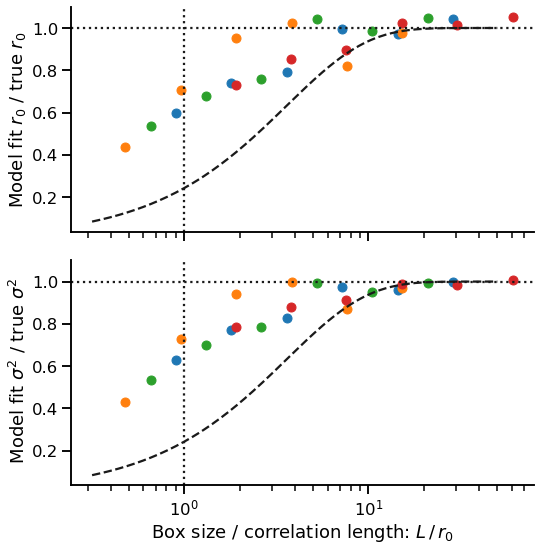

In [65]:
fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    sharex=True,
    sharey=True,
    figsize=(8, 8),
)
for data in [
    fdata_r16,
    fdata,
    fdata_m15,
    fdata_m07,
]:
    x = data["L_over_r0"]
    ax1.plot(x, data["r0mean"], linestyle="none", marker="o")
#    ax1.fill_between(
#        x,
#        data["r0mean"] - data["r0sig"],
#        data["r0mean"] + data["r0sig"],
#        alpha=0.15,
#        lw=0,
#        zorder=-1,
#    )
    ax2.plot(x, data["sig2mean"], linestyle="none", marker="o")
#    ax2.fill_between(
#        x,
#        data["sig2mean"] - data["sig2sig"],
#        data["sig2mean"] + data["sig2sig"],
#        alpha=0.15,
#        lw=0,
#        zorder=-1,
#    )
xgrid = np.logspace(-0.5, 1.7, 200)
for ax in [ax1, ax2]:
    ax.axvline(1.0, color="k", linestyle="dotted")
    ax.axhline(1.0, color="k", linestyle="dotted")
    ax.plot(
        xgrid,
        finite_box_effect(xgrid, scale=3.6),
        color="k",
        linestyle="dashed",
    )


ax1.set(
    #ylabel=r"$r_0$ Ajuste modelo / $r_0$ real",
    ylabel=r"Model fit $r_0$ / true $r_0$",
)
ax2.set(
    xscale="log",
    # yscale="log",
    # xlim=[1, 300],
    # ylim=[0, None],
    #xlabel=r"Tamaño caja / Longitud corr.: $L\, /\, r_0$",
    #ylabel=r" $\sigma^2$ Ajuste modelo / $\sigma^2$ real" ,
    xlabel=r"Box size / correlation length: $L\, /\, r_0$",
    ylabel=r" Model fit $\sigma^2$ / true $\sigma^2$" ,
)
sns.despine()
fig.tight_layout()
fig.savefig("fake-finite-box-fits-ems-fluct.pdf")